In [1]:
import datetime
from datetime import date
from datetime import timedelta
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import os
import sys
import xarray as xr
import pandas as pd
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
from scipy.integrate import trapz
from scipy.stats import norm
from scipy.interpolate import interp1d
from shapely.geometry import Point
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
gap_filled_SWE = 'C:/Users/walimunige.rupasingh/OneDrive - University of Calgary/Documents/Reasearch/Snow_drought_indicator/snowdroughtindex/data/input_data/Case_study/Test/SWE_1979_2022_gapfilled_basin05BB001_Bow.nc'
output_path = 'C:/Users/walimunige.rupasingh/OneDrive - University of Calgary/Documents/Reasearch/Snow_drought_indicator/snowdroughtindex/data/output_data/Case_study/SSWEI/'

In [3]:
# Load the gap filled SWE data and creata dataframes
SWE_gap_filled = xr.open_dataset(gap_filled_SWE)
SWE_gap_filled_df = SWE_gap_filled.to_dataframe()

# select dates 1980-01-01 to 2023-07-31
SWE_gap_filled_df = SWE_gap_filled_df.loc['1980-01-01':'2023-07-31']

display(SWE_gap_filled_df)

SWE  flag donor_stations        lat         lon  \
time       station_id                                                           
1980-01-01 ALE-05BA811        NaN   0.0                 51.700001 -116.466667   
           SCD-AL003     25.00000   0.0                 51.183334 -115.566666   
           ALE-05BA801        NaN   0.0                 51.416668 -116.183334   
           ALE-05BA802        NaN   0.0                 51.433334 -116.166664   
           ALE-05BA806        NaN   0.0                 51.416668 -116.233330   
...                           ...   ...            ...        ...         ...   
2022-07-31 ALE-05BA814        NaN   0.0                 51.683334 -116.383331   
           ALE-05BB803        NaN   0.0                 51.083332 -115.783333   
           ALE-05CA805        NaN   0.0                 51.533333 -116.050003   
           ALE-05BB803P  40.11483   0.0                 51.083332 -115.783333   
           ALE-05CA805P   3.89600   0.0                 51.540554 -116.056389   

                                    station_name  
time       station_id                             
1980-01-01 ALE-05BA811          BOW SUMMIT (OLD)  
           SCD-AL003                       BANFF  
           ALE-05BA801                 BOW RIVER  
           ALE-05BA802           PIPESTONE UPPER  
           ALE-05BA806               MIRROR LAKE  
...                                          ...  
2022-07-31 ALE-05BA814            KATHERINE LAKE  
           ALE-05BB803          SUNSHINE VILLAGE  
           ALE-05CA805            SKOKI MOUNTAIN  
           ALE-05BB803P  SUNSHINE VILLAGE PILLOW  
           ALE-05CA805P       SKOKI LODGE PILLOW  

[217742 rows x 6 columns]

In [4]:
# mean SWE for each day 
SWE_gap_filled_daily = SWE_gap_filled_df.groupby('time').mean()

#keep only time and SWE columns
SWE_gap_filled_daily = SWE_gap_filled_daily.drop(columns=['flag','lat','lon'])


display(SWE_gap_filled_daily)

,SWE
time,
1980-01-01,226.380000
1980-01-02,250.726429
1980-01-03,231.135357
1980-01-04,232.386786
1980-01-05,233.548214
...,...
2022-07-27,21.446791
2022-07-28,21.756103
2022-07-29,22.024836


In [5]:
# Reset the index to make 'time' a column
SWE_gap_filled_daily = SWE_gap_filled_daily.reset_index()

# select complete winter season nov 1st to May 1st next year and add a season year column
winter_season = SWE_gap_filled_daily[(SWE_gap_filled_daily['time'].dt.month >= 11) | (SWE_gap_filled_daily['time'].dt.month <= 5)]
winter_season['Season_year'] = winter_season['time'].dt.year
winter_season['Season_year'] = winter_season['Season_year'].where(winter_season['time'].dt.month >= 10, winter_season['Season_year'] - 1)
# drop 1979
winter_season = winter_season[winter_season['Season_year'] >= 1980]

display(winter_season)


C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_15996\2231112524.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winter_season['Season_year'] = winter_season['time'].dt.year
C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_15996\2231112524.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winter_season['Season_year'] = winter_season['Season_year'].where(winter_season['time'].dt.month >= 10, winter_season['Season_year'] - 1)


,time,SWE,Season_year
305,1980-11-01,23.605000,1980
306,1980-11-02,23.930000,1980
307,1980-11-03,24.100000,1980
308,1980-11-04,24.195000,1980
309,1980-11-05,24.515000,1980
...,...,...,...
15487,2022-05-27,552.421699,2021
15488,2022-05-28,566.509663,2021
15489,2022-05-29,564.152801,2021
15490,2022-05-30,560.143669,2021


In [6]:
# onser of winter (>25.98 mm/day)
onset_SWE = 25.98

# Initialize an empty DataFrame to store the results
onset_to_peak_SWE = pd.DataFrame()

# Iterate through each season year
for year in winter_season['Season_year'].unique():
    # Filter the data for the current season year
    season_data = winter_season[winter_season['Season_year'] == year]
    
    # Find the onset date
    onset_date = season_data[season_data['SWE'] >= onset_SWE]['time'].min()
    
    # Find the peak date
    peak_date = season_data[season_data['SWE'] == season_data['SWE'].max()]['time'].values[0]
    
    # Select data from onset to peak
    selected_data = season_data[(season_data['time'] >= onset_date) & (season_data['time'] <= peak_date)]
    
    # Append the selected data to the result DataFrame
    onset_to_peak_SWE = pd.concat([onset_to_peak_SWE, selected_data])

# Display the result
display(onset_to_peak_SWE)

,time,SWE,Season_year
310,1980-11-06,27.750000,1980
311,1980-11-07,32.155000,1980
312,1980-11-08,39.045000,1980
313,1980-11-09,30.843333,1980
314,1980-11-10,33.706667,1980
...,...,...,...
15450,2022-04-20,612.574682,2021
15451,2022-04-21,584.810744,2021
15452,2022-04-22,594.028859,2021
15453,2022-04-23,595.556964,2021


In [7]:
def perturb_zeros(swe_column):
    """Perturbs zero values with small positive values."""
    swe_array = swe_column.to_numpy()  # Convert to NumPy array for efficient manipulation
    nonzero_min = swe_array[swe_array > 0].min()  # Find the smallest nonzero value
    
    # Generate perturbations for zero values
    perturbation = np.random.uniform(0, nonzero_min / 2, size=swe_column[swe_column == 0].shape)
    
    # Replace zeros with perturbation
    swe_column[swe_column == 0] = perturbation
    
    return swe_column

# Apply to mean_SWE column only
onset_to_peak_SWE['SWE'] = perturb_zeros(onset_to_peak_SWE['SWE'].copy())

display(onset_to_peak_SWE)
print("Number of zeros in mean_SWE:", (onset_to_peak_SWE['SWE'] == 0).sum())


,time,SWE,Season_year
310,1980-11-06,27.750000,1980
311,1980-11-07,32.155000,1980
312,1980-11-08,39.045000,1980
313,1980-11-09,30.843333,1980
314,1980-11-10,33.706667,1980
...,...,...,...
15450,2022-04-20,612.574682,2021
15451,2022-04-21,584.810744,2021
15452,2022-04-22,594.028859,2021
15453,2022-04-23,595.556964,2021


Number of zeros in mean_SWE: 0


In [8]:
# Step 1: Filter for November to May
#df_seasonal = season_data[season_data['Month-Day'].between('11-01', '04-30')]
def integrate_season(group):
    """Integrates SWE values from November 1st to May 1st."""
    # Ensure dates are sorted (though dataset is pre-sorted)
    group = group.sort_values(by='time')
    # Convert dates to numerical days since start of the season
    days_since_start = (group['time'] - group['time'].min()).dt.days
    # Integrate SWE over the period
    total_swe_integration = trapz(group['SWE'], days_since_start)
    return pd.Series({'total_SWE_integration': total_swe_integration})


# Group by season_year and compute integration
Integrated_data = onset_to_peak_SWE.groupby('Season_year').apply(integrate_season).reset_index()

# Inspect results
display(Integrated_data)

,Season_year,total_SWE_integration
0,1980,57140.616391
1,1981,50680.281232
2,1982,45387.507737
3,1983,43681.597932
4,1984,43567.715344
5,1985,67699.160323
6,1986,36822.292789
7,1987,23781.924093
8,1988,29594.650807
9,1989,43554.525167


In [9]:
def gringorten_probabilities(values):
    """Compute Gringorten plotting position probabilities."""
    sorted_values = np.sort(values)
    ranks = np.argsort(np.argsort(values)) + 1  # Rank from smallest to largest
    n = len(values)
    probabilities = (ranks - 0.44) / (n + 0.12)
    return probabilities

# Ensure you're applying the function only to 'total_SWE_integration'
if 'total_SWE_integration' in Integrated_data.columns:
    Integrated_data['Gringorten_probabilities'] = gringorten_probabilities(Integrated_data['total_SWE_integration'])
else:
    print("Error: 'total_SWE_integration' column is missing.")

display(Integrated_data)


,Season_year,total_SWE_integration,Gringorten_probabilities
0,1980,57140.616391,0.867996
1,1981,50680.281232,0.796771
2,1982,45387.507737,0.678063
3,1983,43681.597932,0.583096
4,1984,43567.715344,0.535613
5,1985,67699.160323,0.939221
6,1986,36822.292789,0.345679
7,1987,23781.924093,0.037037
8,1988,29594.650807,0.132004
9,1989,43554.525167,0.511871


In [10]:
def compute_swei(probabilities):
    """Transform probabilities to SWEI using the inverse normal distribution."""
    return norm.ppf(probabilities)

Integrated_data['SWEI'] = compute_swei(Integrated_data['Gringorten_probabilities'])

# Step 5: Classify drought conditions
def classify_drought(swei):
    """Classify drought conditions based on SWEI values."""
    if swei <= -2.0:
        return "Exceptional Drought"
    elif -2.0 < swei <= -1.5:
        return "Extreme Drought"
    elif -1.5 < swei <= -1.0:
        return "Severe Drought"
    elif -1.0 < swei <= -0.5:
        return "Moderate Drought"
    elif -0.5 < swei <= 0.5:
        return "Near Normal"
    elif 0.5 < swei <= 1.0:
        return "Abnormally Wet"
    elif 1.0 < swei <= 1.5:
        return "Moderately Wet"
    elif 1.5 < swei <= 2.0:
        return "Very Wet"
    else:
        return "Extremely Wet"
    
Integrated_data['dought_Classification'] = Integrated_data['SWEI'].apply(classify_drought)

# Display the results
display(Integrated_data)

,Season_year,total_SWE_integration,Gringorten_probabilities,SWEI,dought_Classification
0,1980,57140.616391,0.867996,1.116969,Moderately Wet
1,1981,50680.281232,0.796771,0.830143,Abnormally Wet
2,1982,45387.507737,0.678063,0.462288,Near Normal
3,1983,43681.597932,0.583096,0.209820,Near Normal
4,1984,43567.715344,0.535613,0.089386,Near Normal
5,1985,67699.160323,0.939221,1.548269,Very Wet
6,1986,36822.292789,0.345679,-0.397013,Near Normal
7,1987,23781.924093,0.037037,-1.786156,Extreme Drought
8,1988,29594.650807,0.132004,-1.116969,Severe Drought
9,1989,43554.525167,0.511871,0.029760,Near Normal


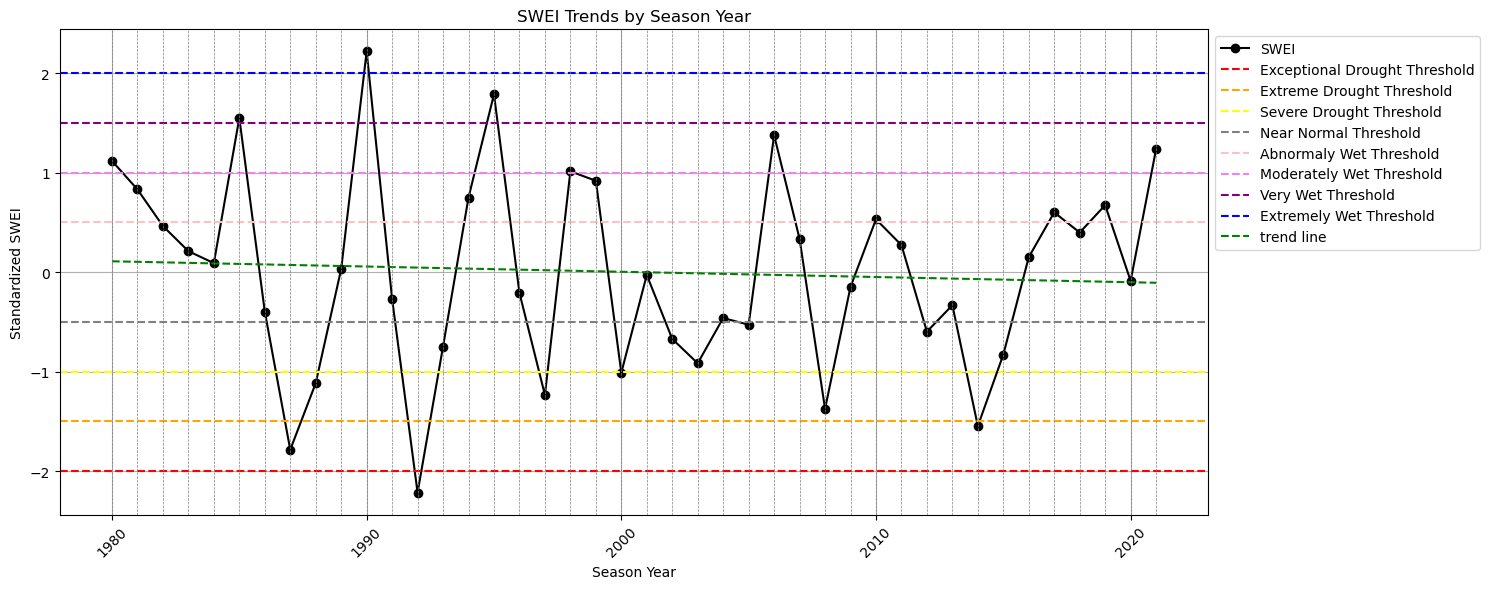

In [16]:
# Extract necessary columns
plot_data= Integrated_data[['Season_year', 'SWEI', 'dought_Classification']]

# Sort by Season_year for better plotting
plot_data = plot_data.sort_values(by='Season_year')
plt.figure(figsize=(15, 6))
plt.plot(plot_data['Season_year'], plot_data['SWEI'], marker='o', label='SWEI', color='black')

# Add thresholds for drought classifications
plt.axhline(-2.0, color='r', linestyle='--', label='Exceptional Drought Threshold')
plt.axhline(-1.5, color='orange', linestyle='--', label='Extreme Drought Threshold')
plt.axhline(-1.0, color='yellow', linestyle='--', label='Severe Drought Threshold')
plt.axhline(-0.5, color='gray', linestyle='--', label='Near Normal Threshold')
plt.axhline(0.5, color='pink', linestyle='--', label='Abnormaly Wet Threshold')
plt.axhline(1.0, color='violet', linestyle='--', label='Moderately Wet Threshold')
plt.axhline(1.5, color='purple', linestyle='--', label='Very Wet Threshold')
plt.axhline(2.0, color='blue', linestyle='--', label='Extremely Wet Threshold')

# trend line
z = np.polyfit(plot_data['Season_year'], plot_data['SWEI'], 1)
p = np.poly1d(z)
plt.plot(plot_data['Season_year'],p(plot_data['Season_year']),"g--", label='trend line')

# Customize the plot
plt.title('SWEI Trends by Season Year')
plt.xlabel('Season Year')
plt.ylabel('Standardized SWEI')
plt.xticks(rotation=45)
# put legend outside the plot right top 
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# Add gridlines for each year
for year in plot_data['Season_year'].unique():
    plt.axvline(year, color='gray', linestyle='--', linewidth=0.5)
plt.grid()
plt.tight_layout()
plt.savefig(output_path + 'SWEI_trends.png')
plt.show()
plt.close()


# Calculate SSWEI using CaSR_Land_SWE 

In [20]:
modeled_SWE = 'C:/Users/walimunige.rupasingh/OneDrive - University of Calgary/Documents/Reasearch/Snow_drought_indicator/snowdroughtindex/data/input_data/Case_study/SWE_P_rearranged.csv'
output_path = 'C:/Users/walimunige.rupasingh/OneDrive - University of Calgary/Documents/Reasearch/Snow_drought_indicator/snowdroughtindex/data/output_data/Case_study/SSWEI/'

In [22]:
# Load the modeled SWE data and create dataframes
SWE_modeled_df = pd.read_csv(modeled_SWE)

display(SWE_modeled_df)

,time,coordinate_id,SWE,P,season_year
0,1980-10-01,3,0.659927,0.148904,1980
1,1980-10-02,3,0.653784,0.000562,1980
2,1980-10-03,3,0.000000,0.000000,1980
3,1980-10-04,3,0.000000,0.000000,1980
4,1980-10-05,3,0.000000,0.001785,1980
...,...,...,...,...,...
270275,2017-09-26,20,17.427170,0.980653,2016
270276,2017-09-27,20,15.287083,0.530347,2016
270277,2017-09-28,20,12.276982,0.000000,2016
270278,2017-09-29,20,8.637960,0.000000,2016


In [23]:
# select winter season nov 1st to May 1st next year and add a season year column
SWE_modeled_df['time'] = pd.to_datetime(SWE_modeled_df['time']) 
winter_season = SWE_modeled_df[(SWE_modeled_df['time'].dt.month >= 11) | (SWE_modeled_df['time'].dt.month <= 5)]
winter_season['Season_year'] = winter_season['time'].dt.year
winter_season['Season_year'] = winter_season['Season_year'].where(winter_season['time'].dt.month >= 10, winter_season['Season_year'] - 1)
# drop 1979
winter_season = winter_season[winter_season['Season_year'] >= 1980]

display(winter_season)

C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_15996\2216831845.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winter_season['Season_year'] = winter_season['time'].dt.year
C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_15996\2216831845.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winter_season['Season_year'] = winter_season['Season_year'].where(winter_season['time'].dt.month >= 10, winter_season['Season_year'] - 1)


,time,coordinate_id,SWE,P,season_year,Season_year
31,1980-11-01,3,15.748659,0.079443,1980,1980
32,1980-11-02,3,15.768864,0.258598,1980,1980
33,1980-11-03,3,15.771650,0.244204,1980,1980
34,1980-11-04,3,15.892332,0.018490,1980,1980
35,1980-11-05,3,15.995457,0.099861,1980,1980
...,...,...,...,...,...,...
270153,2017-05-27,20,360.082886,0.000000,2016,2016
270154,2017-05-28,20,351.108521,0.000000,2016,2016
270155,2017-05-29,20,340.957001,0.006938,2016,2016
270156,2017-05-30,20,324.227142,0.189312,2016,2016


In [24]:
# Apply to mean_SWE column only
winter_season['SWE'] = perturb_zeros(winter_season['SWE'].copy())

display(winter_season)
print("Number of zeros in mean_SWE:", (winter_season['SWE'] == 0).sum())

,time,coordinate_id,SWE,P,season_year,Season_year
31,1980-11-01,3,15.748659,0.079443,1980,1980
32,1980-11-02,3,15.768864,0.258598,1980,1980
33,1980-11-03,3,15.771650,0.244204,1980,1980
34,1980-11-04,3,15.892332,0.018490,1980,1980
35,1980-11-05,3,15.995457,0.099861,1980,1980
...,...,...,...,...,...,...
270153,2017-05-27,20,360.082886,0.000000,2016,2016
270154,2017-05-28,20,351.108521,0.000000,2016,2016
270155,2017-05-29,20,340.957001,0.006938,2016,2016
270156,2017-05-30,20,324.227142,0.189312,2016,2016


Number of zeros in mean_SWE: 0


In [25]:
# Group by season_year and compute integration
Integrated_modeled_data = winter_season.groupby('Season_year').apply(integrate_season).reset_index()

# Inspect results
display(Integrated_modeled_data)

,Season_year,total_SWE_integration
0,1980,36467.785166
1,1981,32379.721850
2,1982,24632.206244
3,1983,28222.679533
4,1984,25412.577222
5,1985,39988.298204
6,1986,30064.073923
7,1987,22057.551669
8,1988,31865.897734
9,1989,41423.979610


In [26]:
# Ensure you're applying the function only to 'total_SWE_integration'
if 'total_SWE_integration' in Integrated_modeled_data.columns:
    Integrated_modeled_data['Gringorten_probabilities'] = gringorten_probabilities(Integrated_modeled_data['total_SWE_integration'])
else:
    print("Error: 'total_SWE_integration' column is missing.")

display(Integrated_modeled_data)

,Season_year,total_SWE_integration,Gringorten_probabilities
0,1980,36467.785166,0.715517
1,1981,32379.721850,0.607759
2,1982,24632.206244,0.149784
3,1983,28222.679533,0.338362
4,1984,25412.577222,0.203664
5,1985,39988.298204,0.796336
6,1986,30064.073923,0.446121
7,1987,22057.551669,0.068966
8,1988,31865.897734,0.553879
9,1989,41423.979610,0.850216


In [28]:
Integrated_modeled_data['SWEI'] = compute_swei(Integrated_modeled_data['Gringorten_probabilities'])

Integrated_modeled_data['dought_Classification'] = Integrated_modeled_data['SWEI'].apply(classify_drought)

# Display the results
display(Integrated_modeled_data)

,Season_year,total_SWE_integration,Gringorten_probabilities,SWEI,dought_Classification
0,1980,36467.785166,0.715517,0.569576,Abnormally Wet
1,1981,32379.721850,0.607759,0.273482,Near Normal
2,1982,24632.206244,0.149784,-1.037358,Severe Drought
3,1983,28222.679533,0.338362,-0.416937,Near Normal
4,1984,25412.577222,0.203664,-0.828606,Moderate Drought
5,1985,39988.298204,0.796336,0.828606,Abnormally Wet
6,1986,30064.073923,0.446121,-0.135469,Near Normal
7,1987,22057.551669,0.068966,-1.483540,Severe Drought
8,1988,31865.897734,0.553879,0.135469,Near Normal
9,1989,41423.979610,0.850216,1.037358,Moderately Wet


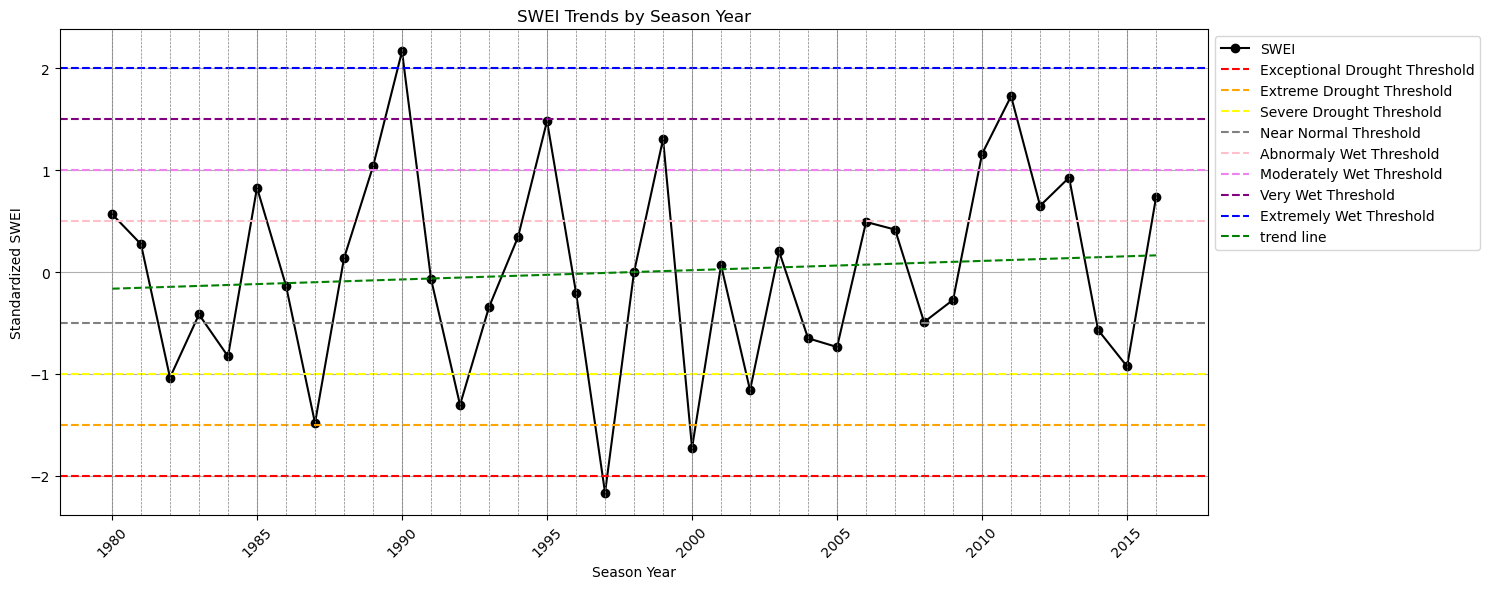

In [29]:
# Extract necessary columns
plot_data= Integrated_modeled_data[['Season_year', 'SWEI', 'dought_Classification']]

# Sort by Season_year for better plotting
plot_data = plot_data.sort_values(by='Season_year')
plt.figure(figsize=(15, 6))
plt.plot(plot_data['Season_year'], plot_data['SWEI'], marker='o', label='SWEI', color='black')

# Add thresholds for drought classifications
plt.axhline(-2.0, color='r', linestyle='--', label='Exceptional Drought Threshold')
plt.axhline(-1.5, color='orange', linestyle='--', label='Extreme Drought Threshold')
plt.axhline(-1.0, color='yellow', linestyle='--', label='Severe Drought Threshold')
plt.axhline(-0.5, color='gray', linestyle='--', label='Near Normal Threshold')
plt.axhline(0.5, color='pink', linestyle='--', label='Abnormaly Wet Threshold')
plt.axhline(1.0, color='violet', linestyle='--', label='Moderately Wet Threshold')
plt.axhline(1.5, color='purple', linestyle='--', label='Very Wet Threshold')
plt.axhline(2.0, color='blue', linestyle='--', label='Extremely Wet Threshold')

# trend line
z = np.polyfit(plot_data['Season_year'], plot_data['SWEI'], 1)
p = np.poly1d(z)
plt.plot(plot_data['Season_year'],p(plot_data['Season_year']),"g--", label='trend line')

# Customize the plot
plt.title('SWEI Trends by Season Year')
plt.xlabel('Season Year')
plt.ylabel('Standardized SWEI')
plt.xticks(rotation=45)
# put legend outside the plot right top 
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# Add gridlines for each year
for year in plot_data['Season_year'].unique():
    plt.axvline(year, color='gray', linestyle='--', linewidth=0.5)
plt.grid()
plt.tight_layout()
plt.savefig(output_path + 'modelde_SWEI_trends.png')
plt.show()
plt.close()
